# Predict with pre-trained CNNs
This notebook contains all the code you need to use a pre-trained OpenSoundscape convolutional neural network model (CNN) to make predictions on your own data.

Before attempting this tutorial, install OpenSoundscape by following the instructions on the OpenSoundscape website, [opensoundscape.org](http://opensoundscape.org/). 

More detailed tutorials about data preprocessing, training CNNs, and customizing prediction methods can be found in the other tutorial notebooks on [opensoundscape.org](http://opensoundscape.org/). 

## Load required packages

We will load several imports from OpenSoundscape. First, load the `AudiotoSpectrogramPreprocessor` class from the `preprocess.preprocessors` module. Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model. 

In [1]:
from opensoundscape.preprocess.preprocessors import AudioToSpectrogramPreprocessor

Second, the `cnn` module provides classes for training and prediction with various structures of CNNs. For this example, load the `Resnet18Binary` class, used for models made with the Resnet18 architecture for predicting the presence or absence of a species (a "binary" classifier).

In [2]:
# The cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import Resnet18Binary

Third, the `run_command` function from the `helpers` module allows us to run command line commands from inside OpenSoundscape scripts.

In [3]:
from opensoundscape.helpers import run_command

Finally, load some additional packages and perform some setup for the Jupyter notebook.

In [4]:
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob

In [5]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

## Prepare audio data for prediction

To run predictions on your audio data, you will need to have your audio already split up into the clip lengths that the model expects to receive. If your audio data are not already split, see the demonstration of the `Audio.split()` method in the `audio_and_spectrogram` notebook.

You can check the length of clips that the model to receives in the model's notes when you download it. This is often, but not always, 5.0 seconds.

### Download audio files

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. OR download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [6]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

### Generate a Preprocessor object

In addition to having audio clips of the correct length, you will need to create a Preprocessor object that loads audio samples for the CNN. 

First, generate a Pandas DataFrame with the index containing the paths to each file, as shown below.

In [7]:
# collect a list of audio files
file_list = glob('./woodcock_labeled_data/*.wav')

# create a DataFrame with the audio files as the index
audio_file_df = pd.DataFrame(index=file_list)

Next, use that DataFrame to create a Preprocessor object suitable for your application. Use the argument `return_labels=False`, as our audio to predict on does not have labels.

If the model was trained with any special preprocesor settings, you should apply those settings here. For pretrained models created by the Kitzes Lab, see the model's notes from its download page for the exact code to use here.

In [8]:
# create a Preprocessor object 
# we use the option "return_labels=False" because our audio to predict on does not have labels
from opensoundscape.preprocess.preprocessors import AudioToSpectrogramPreprocessor
prediction_dataset = AudioToSpectrogramPreprocessor(audio_file_df, return_labels=False)

## Models trained with OpenSoundscape v0.5.x
Check the model notes page for the appropriate model class to use and import the correct class from the `cnn` module.

In [9]:
from opensoundscape.torch.models.cnn import Resnet18Binary

For the purpose of demonstration, let's generate a new Resnet18 model for binary prediction and save it to our local folder. 

If you download a pre-trained model, you can skip this cell.

In [10]:
model = Resnet18Binary(classes=['absent','present'])
model.save('./demo.model')

created PytorchModel model object with 2 classes
Saving to demo.model


Next, provide the model class's `from_checkpoint()` method with the path to your downloaded model.

In [11]:
# load the model into the appropriate model class
model = Resnet18Binary.from_checkpoint('./demo.model')

created PytorchModel model object with 2 classes
loading weights from saved object


Generate predictions as follows. The `predict` method returns three arguments: scores, thresholded predictions, and labels. For unthresholded prediction on unlabeled data, only the first one is relevant, so discard the other returns are discarded using `scores, _, _`.

In [12]:
# call model.predict() with the Preprocessor to generate predictions
scores, _, _ = model.predict(prediction_dataset)

(29, 2)


Look at the scores of the first 5 samples.

In [13]:
#look at the scores of the first 5 samples
scores.head()

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0.635846,-0.132521
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,0.184235,-0.182311
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0.697698,0.179681
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0.660510,0.189465
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0.537445,-0.122072


### Options for prediction

The code above returns the raw predictions of the model without any post-processing (such as a softmax layer or a sigmoid layer). 

For details on how to use the `predict()` function for post-processing of predictions and to generate binary 0/1 predictions of class presence, see the "Basic training and prediction with CNNs" tutorial notebook. But, as a quick example, let's generate scores using the following settings:
* a softmax layer, to make the prediction scores for both classes sum to 1
* a logit layer, to map the prediction scores from [0, 1] to (-inf, +inf)

We can also use the `binary_preds` argument to generate 0/1 predictions for each sample and class. For presence/absence models, use the option `binary_preds='single_target'`. For multi-class models, think about whether each clip should be labeled with only one class (single target) or whether each clip could contain multiple classes (`binary_preds='multi_target'`)

In [14]:
scores, binary_predictions, _ = model.predict(
    prediction_dataset,
    activation_layer='softmax_and_logit',
    binary_preds='single_target'
)

(29, 2)


As before, the `scores` are continuous variables, but now have been softmaxed and logited:

In [15]:
scores.head(2)

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0.768367,-0.768367
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,0.366546,-0.366545


We also have an additional output, the binary 0/1 ("absent" vs "present") predictions generated by the model:

In [16]:
binary_predictions.head(2)

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,1.0,0.0
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1.0,0.0


It is often helpful to look at a histogram of the scores for the positive class. We typically apply softmax and logit to predictions before plotting them as histograms.

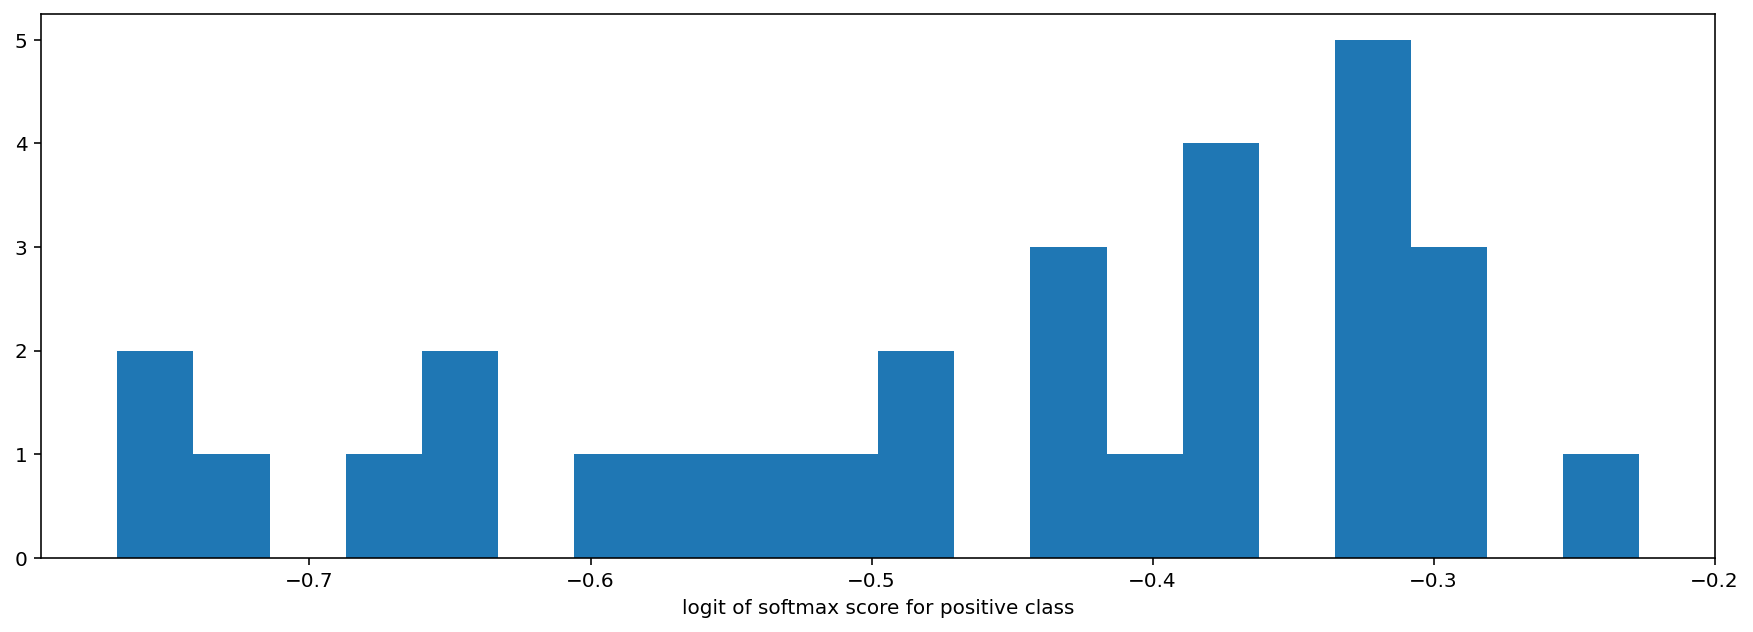

In [17]:
_ = plt.hist(scores['present'],bins=20)
_ = plt.xlabel('logit of softmax score for positive class')

## Models trained with OpenSoundscape 0.4.x
One set of our publicly availably [binary models for 500 species](https://pitt.app.box.com/s/3048856qbm9x55yi3zfksa3fide5uuf4) was created with an older version of OpenSoundscape. These models require a little bit of manipulation to load into OpenSoundscape 0.5.x and onward.

First, let's download one of these models (it's stored in a .tar format) and save it to the same directory as this notebook in a file called `opso_04_model_acanthis-flammea.tar`

In [18]:
%%bash
curl -L https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar -o ./opso_04_model_acanthis-flammea.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--     7
100 42.9M  100 42.9M    0     0  4659k      0  0:00:09  0:00:09 --:--:-- 6206k


Next, load the weights from that model into an OpenSoundscape model object with the following code:

In [19]:
from opensoundscape.torch.models.cnn import PytorchModel
from opensoundscape.torch.architectures.cnn_architectures import resnet18
import torch

# load the tar file into a dictionary 
# (you could change this to the location of any .tar file on your computer)
opso_04_model_tar_path = "./opso_04_model_acanthis-flammea.tar"
opso_04_model_dict = torch.load(opso_04_model_tar_path)

# create a resnet18 binary model 
# (all models created with Opensoundscape 0.4.x are 2-class resnet18 architectures)
architecture = resnet18(num_classes=2,use_pretrained=False)
model = PytorchModel(classes=['negative','positive'],architecture=architecture)

# load the model weights into our model object
# now, our model is equivalent to the trained model we downloaded
model.network.load_state_dict(opso_04_model_dict['model_state_dict'])

created PytorchModel model object with 2 classes


<All keys matched successfully>

Now, we can use the model as normal to create predictions on audio. We'll use the same `prediction_dataset` from above. 

Remember to choose the `activation_layer` you desire. In this example, we'll assume we just want to generate scores, not binary predictions. We'll apply a softmax layer, then the logit transform, to the scores using the `activation_layer="softmax_and_logit"` option. This will generate the type of scores that are useful for plotting score histograms, among other things. 

In [20]:
# generate predictions on our dataset
predition_scores_df,_,_ = model.predict(prediction_dataset, activation_layer='softmax_and_logit')

predition_scores_df.head(3)

(29, 2)


,negative,positive
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,3.953401,-3.953400
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,3.650462,-3.650461
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,2.165398,-2.165398


Remove the downloaded files to clean up.

In [21]:
from glob import glob
for p in glob('./woodcock_labeled_data/*'):
    Path(p).unlink()
for p in glob('./*.model'):
    Path(p).unlink()
for p in glob('./*.tar'):
    Path(p).unlink()